# Code for protein sequence alignment
Returns a PNG showing similarities between the sequences

In [46]:
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
import os
import subprocess

In [2]:
# Defining colors for each protein residue
def get_colors_protein(seqs):
    """Make colors for bases in sequence

    Args:
        seqs (list, str): List or string with protein sequence

    Returns:
        list: List with colors
    """
    text = [i for s in list(seqs) for i in s]
    aa_colors = {
    'A': 'red',    # Alanine
    'R': 'blue',   # Arginine
    'N': 'green',  # Asparagine
    'D': 'yellow', # Aspartic acid
    'C': 'orange', # Cysteine
    'Q': 'purple', # Glutamine
    'E': 'cyan',   # Glutamic acid
    'G': 'magenta',# Glycine
    'H': 'pink',   # Histidine
    'I': 'brown',  # Isoleucine
    'L': 'gray',   # Leucine
    'K': 'lime',   # Lysine
    'M': 'teal',   # Methionine
    'F': 'navy',   # Phenylalanine
    'P': 'olive',  # Proline
    'S': 'maroon', # Serine
    'T': 'silver', # Threonine
    'W': 'gold',   # Tryptophan
    'Y': 'skyblue',# Tyrosine
    'V': 'violet', # Valine
    '-':'white'
    }
    colors = [aa_colors[i] for i in text]
    return colors

## Bokeh sequence plotter
Code using the Bokeh-panel strategy

In [3]:
import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.plotting import output_file, save

In [4]:
def view_alignment_bokeh(aln, fontsize="9pt", plot_width=800, file_name='alignment'):
    """Bokeh sequence alignment view
    From: https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner"""
    # The function takes a biopython alignment object as input.
    # rec is the alignment record: Each one of the entries given as input
    seqs = [rec.seq for rec in (aln)] # Each sequence input
    ids = [rec.id for rec in aln] # Each entry ID
    text = [i for s in list(seqs) for i in s] #Al units joind on same list
    # List with ALL colors
    colors = get_colors_protein(seqs)    
    N = len(seqs[0]) # What if they're not the same length???
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5 # Just to make the rectangles twice the size and the letter in the middle
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    print(f'Aligning {S} sequences of lenght {N}')
    # ColumnDataSource is a JSON dict that maps names to arrays of values
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*10+50
    x_range = Range1d(0, N+1, bounds='auto') # (start, end)
    if N>150:
        viewlen=150
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, width=plot_width, height=plot_height,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    # Rect simply places rectangles of wifth "width" into the positions defined by x and y
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    # Source does mapping from keys in rects to values in ColumnDataSource definition
    p.add_glyph(source, rects) 
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, width=plot_width, height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)   
    # Text does the same thing as rectangles but placing letter (or words) instead, aligned accordingly   
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = True
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')

    output_file(filename=f"{file_name}.html", title="Alignment result")
    save(p)
    
    return p

Testing with two sequences of equal length

In [5]:
# Note here: The aminoacid sequences must be the same length, with missing units represented as '-'
aln = AlignIO.read('covid.aln','fasta')
p = view_alignment_bokeh(aln, plot_width=1500, file_name='simple_alignment')
# pn.pane.Bokeh(p)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text_font='monospace' [no close matches] {renderer: GlyphRenderer(id='eab2c717-8c61-496f-b296-58931aced063', ...)}


Aligning 2 sequences of lenght 301


## BLAST-Mafft-Bokeh sequence alignment
*Input reference sequence on BLAST to query for similar sequences, select seqs in the output to finally generate an HTML file with multi seq alignment*

---This implementation needs the installation of both Bokeh and also the command-line mafft program---

In [131]:
def parse_blast(results_file, verbose):
    from Bio.Blast import NCBIXML
    # Parse results
    E_VALUE_THRESH = 1e-20 

    matches_seq = []
    matches_id = []
    scores = []

    for record in NCBIXML.parse(open(results_file)): 
        if record.alignments: 
            if verbose:
                print("\n") 
                print("query: %s" % record.query[:100]) 
            query_seqs = []
            query_ids = []
            query_scores = []
            for align in record.alignments: 
                for hsp in align.hsps: 
                    if hsp.expect < E_VALUE_THRESH: 
                        # Print sequence identity, title, and gapless sequence substring that aligns
                        hsps0 = align.hsps[0]
                        sequence_to_model = hsps0.sbjct.replace('-','')
                        pidentity = round(100.0 * hsps0.identities / (hsps0.query_end-hsps0.query_start+1), 2)
                        if verbose:
                            print(f'length {hsps0.identities}, score {pidentity}: {align.title}')# {sequence_to_model}')
                        query_seqs.append(sequence_to_model)
                        query_ids.append(align.title)
                        query_scores.append(pidentity)
        matches_seq.append(query_seqs)
        matches_id.append(query_ids)
        scores.append(query_scores)

    return matches_seq, matches_id, scores

def get_blast_seqs(seq_source, input_type="fasta", save_file="results.xml", nalign=500, database="refseq_protein", verbose=True):
    """Run a BLAST search on a protein sequence.
    Args:
        seq_source (string, list): Source with the sequence.
        input_type (str, optional): Type of sequence source ["pre-cal", "fasta", "sequence"]. Defaults to "fasta".
        save_file (str, optional): Name of output file storing BLAST results. Defaults to "results.xml".

    Returns:
        (list, list): Matched sequences, Matched IDs
    """
    from Bio.Blast import NCBIWWW
    
    if input_type == "pre-calc":
        matches_seq, matches_id, scores = parse_blast(seq_source, verbose)
        return matches_seq, matches_id, scores
    elif input_type == "fasta":
        # Input is file name
        sequence = open(seq_source).read() 
    elif input_type == "sequence":
        # Input is sequence
        sequence = seq_source
    else: # Another source?
        return
    
    # Retrieve blastp results
    program = 'blastp' # protein sequence BLAST
    database =  database # non-redundant protein database
    alignments = nalign # number of alignments to retrieve
    result_handle = NCBIWWW.qblast(program, database, sequence, alignments=alignments) 

    with open(save_file, 'w') as file: 
        blast_results = result_handle.read() 
        file.write(blast_results)

    matches_seq, matches_id, scores = parse_blast(save_file, verbose)

    return matches_seq, matches_id, scores

def process_align_data(input_alignment, output_file):
    ''' Modify sequences in multi-seq alignment to remove gap characters '-' 
    '''
    alignment = SeqIO.parse(input_alignment, "fasta")
    filtered_sequences = []
    for rec in alignment:
        # Remove gap characters '-' from the sequence
        filtered_sequence = rec.seq.ungap("-")
        # Update SeqRecord with the filtered sequence
        filtered_seq_record = SeqRecord(filtered_sequence, id=rec.id, description=rec.description)
        filtered_sequences.append(filtered_seq_record)

    SeqIO.write(filtered_sequences, output_file, "fasta")
    return output_file

In [165]:
# Calculate homologous sequences (this takes some time)
# matches_seq, matches_id = get_blast_seqs('covid.aln', input_type="fasta", save_file="results.xml", nalign=500, database="refseq_protein")

# Retrieve pre-computed file
matches_seq, matches_id, scores = get_blast_seqs("results.xml", input_type="pre-calc")



query: MERS-CoV Mpro
length 301, score 100.0: ref|YP_007188578.1| ORF1a polyprotein [Betacoronavirus England 1]
length 301, score 100.0: ref|YP_009047203.1| 1A polyprotein [Middle East respiratory syndrome-related coronavirus]
length 301, score 100.0: ref|YP_007188577.3| ORF1ab polyprotein [Betacoronavirus England 1]
length 301, score 100.0: ref|YP_009047202.1| 1AB polyprotein [Middle East respiratory syndrome-related coronavirus]
length 301, score 100.0: ref|YP_009047217.1| nsp5 protein [Middle East respiratory syndrome-related coronavirus] >ref|YP_009047233.1| nsp5 protein [Middle East respiratory syndrome-related coronavirus] >ref|YP_009944285.1| nsp5 [Betacoronavirus England 1] >ref|YP_009944296.1| nsp5 [Betacoronavirus England 1]
length 288, score 95.68: ref|YP_009361855.1| ORF1a polyprotein [Bat coronavirus]
length 288, score 95.68: ref|YP_009361856.2| ORF1ab polyprotein [Bat coronavirus]
length 248, score 82.39: ref|YP_009944343.1| nsp5 [Pipistrellus bat coronavirus HKU5] >ref

Select sequences to visualize from a checklist with BLAST results (example for MERS-CoV)

In [9]:

from ipywidgets import Layout, Checkbox, Box

items_layout = Layout(flex='1 1 auto',
                      width='auto')    

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    border='',
                    width='80%')

data = [(' '.join(matches_id[0][s].split(' ')[1:])) for s in range(len(matches_id[0]))]
ref_nums = [(''.join(matches_id[0][s].split(' ')[0])) for s in range(len(matches_id[0]))]
items = [Checkbox(description=w, layout=items_layout) for w in data]
output = Box(children=items, layout=box_layout)
print("Choose which proteins you want to compare with the REF: \n")
display(output)

Choose which proteins you want to compare with the REF: 



Box(children=(Checkbox(value=False, description='ORF1a polyprotein [Betacoronavirus England 1]', layout=Layout…

Comparing the chosen sequences

In [144]:
# Add selected sequences to array
selected_labels = [ref_nums[0]]#['REF']
selected_description= [items[0].description]
selected_seqs = [matches_seq[0][0]]

for i in range(0, len(items)):
    if items[i].value == True:
        selected_seqs.append(matches_seq[0][i])
        selected_labels.append(ref_nums[i])
        selected_description.append(items[i].description)
records = []
for r in range(len(selected_labels)):
    rec = SeqRecord(Seq(selected_seqs[r]), id=selected_labels[r],  description=selected_description[r])
    records.append(rec)

# Run alignment with MAFFT
input_file = "covid_BLAST.aln"
out_file = "output.fasta"
SeqIO.write(records, input_file, "fasta")
cmd = f"mafft {input_file} > {out_file}"
subprocess.run(cmd, shell=True)

align = AlignIO.read(out_file, "fasta")

# Generate output file without gaps for later steps
clean_output = process_align_data(out_file, "blast_selection.fasta")

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 6
done.

Constructing a UPGMA tree (efffree=0) ... 
    0 / 6
done.

Progressive alignment 1/2... 
STEP     5 / 5 
done.

Making a distance matrix from msa.. 
    0 / 6
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 6
done.

Progressive alignment 2/2... 
STEP     5 / 5 
done.

disttbfast (aa) Version 7.490
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option

In [145]:
p = view_alignment_bokeh(align, plot_width=1500, file_name='alignment_blast') 

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text_font='monospace' [no close matches] {renderer: GlyphRenderer(id='1696524c-34c1-4e13-8ed3-a27f1aa3a3d8', ...)}


Aligning 6 sequences of lenght 305


Retrieve PDB for chosen sequences using prody

In [162]:

def retrieve_pdb_prody(seq, label, pre_gen=False, min_id_match=99):
    ''' Retrieve the PDB record of a given sequence'''
    from pathlib import Path
    import pickle
    import prody

    folder_for_bkps = "pdb_search_bkp/"
    Path(folder_for_bkps).mkdir(parents=True, exist_ok=True)
    record_name = f"{folder_for_bkps}{label}_blast_record.pkl"

    if pre_gen: # the search was done before 
        # Check if the file exists
        record_path = Path(record_name)
        if not record_path.exists():
            raise ValueError("pre_gen was set to True but the file does not exist. Set to False to generate the record")
    else:
        # Find pdb matching given sequence
        blast_record = prody.blastPDB(seq, filename=folder_for_bkps + "test")
        print("saving in ", record_name)
        # Save data on pkl file
        pickle.dump(blast_record, open(record_name, 'wb'))

    # Load pickle data 
    blast_record = pickle.load(open(record_name, 'rb'))
    best = blast_record.getBest()
    print(f"The best match is '{best['pdb_id']}' with a match of {best['percent_identity']}%")
    hits = blast_record.getHits(percent_identity=min_id_match, percent_overlap=90)
    
    if len(hits) == 0: # The record doesn't have a PDB with high confidence
        filename = get_seq_alphafold(seq)
    else:
        # Return the pdb entry with the max alignment and max resolution (if there are multiple matches)
        best_pdb_record = choose_best_pdb_entry(hits, best['percent_identity'])
        filename = prody.fetchPDB(best_pdb_record, folder=folder_for_bkps)
        subprocess.run(["gunzip", filename])
    return filename

def get_seq_alphafold(seq, seq_name, file_dir):
    ''' Generate alphafold structure of a given sequence'''
    print("Alphafold has not been implemented")

    # Write CSV file for the sequence
    import csv
    csv_file_name = file_dir + "mers_input.csv"
    with open(csv_file_name, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # Write the header
        writer.writerow(["id", "sequence"])
        # Write the sequence
        writer.writerow([seq_name + "_{}", seq])
    
        return csv_file_name

import sys, requests

def request_rcsb_pdbid(pdb_id):
    """
    A function to request a protein entry from the UniProt API with a pdb ID
    """
    requestURL = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})
    if not r.ok:
        r.raise_for_status()
        sys.exit()
    return r.json()


def check_resolution(pdb_id):
    fjson = request_rcsb_pdbid(pdb_id)
    return fjson['rcsb_entry_info']['resolution_combined'][0]

def choose_best_pdb_entry(hits, best_match_percent):
    ''' If a sequence have different PDB files all with the same alignment match, we choose and retrieve the one with the highest resolution'''
    max_res = 10 # some unrealistically large number?
    best_pdb_record = ""
    for h in hits:
        id_match = hits[h]['percent_identity']
        if id_match == best_match_percent: 
            res = check_resolution(h)
            if res < max_res:
                best_pdb_record = h
                max_res = res
        else: # We're only interested in the entries with the max possible alignment
            break
    print(f"The best PDB entry is {best_pdb_record}, with match {best_match_percent}% and res {max_res}A")
    return best_pdb_record

Using ProDy to find and retrieve best PDBs.  
**NOTE:** This implementation should technically work, but for some reason, the Blast queries ProDy is doing take a long time to run and the search times-out. It's commented for now.   
I'm temporarily (*or not?*) building a solution based on the BLAST function I wrote above.

In [147]:
'''
for rec in align:
    raw_label = (rec.id).split('|')
    
    label = raw_label[0]
    if len(raw_label) > 1:
        label_name = raw_label[1].split('.')[0]
        label_chain = raw_label[1].split('.')[-1]
        label = f"{label_name}_{label_chain}"
    seq = str(rec.seq).replace('-','')
    print("Retrieving best pdb match for ", label_name, seq)
    retrieve_pdb_prody(seq, label, pre_gen=False, min_id_match=99)
'''

'\nfor rec in align:\n    raw_label = (rec.id).split(\'|\')\n    \n    label = raw_label[0]\n    if len(raw_label) > 1:\n        label_name = raw_label[1].split(\'.\')[0]\n        label_chain = raw_label[1].split(\'.\')[-1]\n        label = f"{label_name}_{label_chain}"\n    seq = str(rec.seq).replace(\'-\',\'\')\n    print("Retrieving best pdb match for ", label_name, seq)\n    retrieve_pdb_prody(seq, label, pre_gen=False, min_id_match=99)\n'

Manual implementation of PDB search because ProDy has problems with retrieving data. Only `retrieve_pdb_prody` is modified, the other functions above are still used.  
**NOTE** I'm still using ProDy to retrieve PDB files (`prody.fetchPDB`). If we're keeping this solution, it may be worth it to implement that by hand too (to minimize unnecessary package imports)

In [138]:
class pdb_record():
    def __init__(self, label:str, query_seq:str, description:str) -> None:
        self.label = label
        self.description = description
        self.seq = query_seq


def retrieve_pdb_temp(seq_file, blast_file="results.xml", pre_gen=False, min_id_match=99, pdb_folder="pdb_search_bkp/"):
    ''' Retrieve the PDB record of a given sequence. Temp solution to prody'''
    from pathlib import Path
    import prody

    folder_for_bkps = pdb_folder
    Path(folder_for_bkps).mkdir(parents=True, exist_ok=True)
    record_name = f"{folder_for_bkps}{blast_file}"

    if pre_gen: # the search was done before 
        # Check if the file exists
        record_path = Path(record_name)
        if not record_path.exists():
            raise ValueError("pre_gen was set to True but the file does not exist. Set to False to generate the record")
    else:
        # Find pdb matching given sequence
        matches_seq, matches_id, scores = get_blast_seqs(seq_file, input_type="fasta", save_file=record_name, nalign=500, database="pdb", verbose=False)
        print("saving in ", record_name)

    # Load original sequence names and descriptors for reference
    pdb_file_record = []
    for seq_record in SeqIO.parse(seq_file, "fasta"):
        seq_id = seq_record.id
        seq_description = seq_record.description
        pdb_file_record.append(pdb_record(seq_id, seq_record.seq, seq_description))

    # Load data 
    matches_seq, matches_id, scores = get_blast_seqs(record_name, input_type="pre-calc", verbose=False)
    # best_ids = matches_id[:,0]
    best_scores = [max(s) for s in scores]
    # print(f"The best matches are '{best_ids}' with scores {best_scores}")
    
    match_hits = parse_pdb_blast_results(matches_seq, matches_id, scores, min_score=min_id_match)

    
    for i, hits in enumerate(match_hits):
        if len(hits) == 0: # The record doesn't have a PDB with high confidence
            filename = get_seq_alphafold(hits)
            get_seq_alphafold(pdb_file_record[i].seq, 'some_seq', folder_for_bkps)
            pdb_file_record[i].pdb_file = filename
            pdb_file_record[i].pdb_id = None
            
        else:
            # Return the pdb entry with the max alignment and max resolution (if there are multiple matches)
            best_pdb_record = choose_best_pdb_entry(hits, best_scores[i])
            filename = prody.fetchPDB(best_pdb_record, folder=folder_for_bkps)
            subprocess.run(["gunzip", filename])
            pdb_file_record[i].pdb_file = filename
            pdb_file_record[i].pdb_id = best_pdb_record

    return pdb_file_record


def parse_pdb_blast_results(blast_seq, blast_ids, blast_scores, min_score):
    ''' For a pdb database searchm extract pdb ids with a minimum score (Temp fix to prody).
        Outputs are lists because iterables are needed for functions down the pipeline.
    '''

    assert len(blast_ids) == len(blast_scores) == len(blast_seq)

    match_hits = []
    for q in range(len(blast_ids)): # Loop over queries
        hits = {}
        for e in range(len(blast_ids[q])): # Loop over BLAST entries
            if blast_scores[q][e] >= min_score:
                raw_id = blast_ids[q][e].split(' ')
                pdb_id = raw_id[0].split('|')[1].lower()
                hits[pdb_id] = {}
                hits[pdb_id]['percent_identity'] = blast_scores[q][e]
                hits[pdb_id]['sequence'] = blast_seq[q][e]

        match_hits.append(hits)

    return match_hits

The best PDB entry (if any) for each alignment sequence is saved on the provided `pdb_folder`.

In [148]:
pdb_file_record = retrieve_pdb_temp(clean_output, blast_file="results_pdb.xml", pre_gen=True, min_id_match=99, pdb_folder="pdb_search_bkp/")

@> PDB file is found in working directory (pdb_search_bkp/7xry.pdb).


The best PDB entry is 7xry, with match 100.0% and res 1.99A


gunzip: pdb_search_bkp/7xry.pdb: unknown suffix -- ignored
@> PDB file is found in working directory (pdb_search_bkp/6xhl.pdb).


The best PDB entry is 6xhl, with match 100.0% and res 1.471A


gunzip: pdb_search_bkp/6xhl.pdb: unknown suffix -- ignored
@> PDB file is found in working directory (pdb_search_bkp/6xhl.pdb).


The best PDB entry is 6xhl, with match 100.0% and res 1.471A


gunzip: pdb_search_bkp/6xhl.pdb: unknown suffix -- ignored
@> PDB file is found in working directory (pdb_search_bkp/6xhl.pdb).


The best PDB entry is 6xhl, with match 100.0% and res 1.471A


gunzip: pdb_search_bkp/6xhl.pdb: unknown suffix -- ignored
@> PDB file is found in working directory (pdb_search_bkp/7wqb.pdb).


The best PDB entry is 7wqb, with match 100.0% and res 1.87A


gunzip: pdb_search_bkp/7wqb.pdb: unknown suffix -- ignored
@> PDB file is found in working directory (pdb_search_bkp/3f9f.pdb).


The best PDB entry is 3f9f, with match 100.0% and res 2.3A


gunzip: pdb_search_bkp/3f9f.pdb: unknown suffix -- ignored


The sequence label and descriptor, query sequence, and pdb_id found in the database, are stored in the `pdb_record` class.

In [159]:
for rec in pdb_file_record:
    if rec.pdb_id:
        print(f"For the sequence {rec.label}: {rec.seq[:20]}..., a PDB was found and save in {rec.pdb_file}.")
    else:
        print(f"For the sequence {rec.label}: {rec.seq[:20]}..., no PDB entry was found.")

For the sequence ref|YP_007188578.1|: SGLVKMSHPSGDVEACMVQV..., a PDB was found and save in pdb_search_bkp/7xry.pdb.
For the sequence ref|YP_001039952.1|: SGFRKMAFPSGKVEGCMVQV..., a PDB was found and save in pdb_search_bkp/6xhl.pdb.
For the sequence ref|YP_009944273.1|: SGFRKMAFPSGKVEGCMVQV..., a PDB was found and save in pdb_search_bkp/6xhl.pdb.
For the sequence ref|YP_009555250.1|: SGFRKMAFPSGKVEGCMVQV..., a PDB was found and save in pdb_search_bkp/6xhl.pdb.
For the sequence ref|NP_150074.1|: SGFRKMAFPSGKVEGCMVQV..., a PDB was found and save in pdb_search_bkp/7wqb.pdb.
For the sequence ref|YP_009924317.1|: SGFRKMAFPSGKVEGCMVQV..., a PDB was found and save in pdb_search_bkp/3f9f.pdb.


All of the sequences have crystal pdb entries, so I'm going to use run ColabFold with one of the sequences for testing.  
Right now the `get_seq_alphafold` function only does generates the input csv file with the sequence, but will integrate with the lilac workflow later.

In [164]:
csv_file = get_seq_alphafold(pdb_file_record[1].seq, "MERS_CoV", "pdb_search_bkp/")
print(f"Copy the files {csv_file} and {pdb_file_record[1].pdb_file} to the ColabFold working directory")


Alphafold has not been implemented
Copy the files pdb_search_bkp/mers_input.csv and pdb_search_bkp/6xhl.pdb to the ColabFold working directory


## Implementation with Matplotlib (**Not optimized**)

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

Implementing a sequence reader class

In [25]:
class Seq_reader():

    def __init__(self, seq, format='list'):
        """Read the sequences for alignment as a file or list, and returns data

        Args:
            seq (str, list, numpy ndarray): The alignment sequences as a list of lists or tuples,
                                            (seq id, seq)
            format (str): Format of the input: {list, fasta}
        """

        if format == 'list':
            if isinstance(seq, list) or isinstance(seq, np.ndarray):
                if len(seq[0])==2 and isinstance(seq[0][0], str):
                    self.ids = [s[0] for s in seq]
                    self.seqs = [s[1] for s in seq]
                else: 
                    raise ValueError("The format of each sequence must be a list/tuple (seqID, seq)")
            else:
                raise ValueError("Format 'list' only takes a list or np.ndarray, please specify the correct format")
        elif format == 'fasta':
            if isinstance(seq, str):
                self.seqs, self.ids = self.read_fasta(seq)
            else:
                raise ValueError("'fasta' format takes a sequence file, please specify the correct format")

        else:
            raise NotImplementedError("Only list and fasta inputs are implemented...for now")
        
    def read_fasta(self, file):
        """Read a valid fasta file

        Args:
            file (str): Fasta file
        """
        seqs = []
        ids = []
        start = -1
        with open(file, 'r') as f:
            for i, line in enumerate(f):
                if line[0] == ">":
                    start = i
                    label = line[1:].split()
                    ids.append(label[0])
                if start>-1 and i==start+1:
                    seqs.append(line.strip())
        if start < 0:
            raise RuntimeError("No sequences were read in the file. Make sure each label is initialized with '>'")
        else:
            return seqs, ids 
    
    def adjust_length(self):
        """If the sequences have different length, pads on the right the missing sequences

        Returns:
            list: Adjusted strings
        """
        # Get the length of the longest seq string
        longest =  max(len(s) for s in self.seqs)

        # Adjust all strings to have the same length
        adjusted_strings = [s.ljust(longest, '-') for s in self.seqs]
        self.seqs = adjusted_strings
        return 

In [26]:
def view_alignment(seq, fontsize=9, plot_height=1, plot_width=10, img_file="alignment.png"):
    """Implementation of alignment function, that returns a png with the alignment view

    Args:
        seq (Seq_reader): Object with sequences info
        fontsize (int, optional): Printing font of aminoacids. Defaults to 9.
        plot_height (int, optional): Plot height. Defaults to 1.
        plot_width (int, optional): Plot width. Defaults to 10.
        img_file (str, optional): Name of the image file with the final alignment.

    Returns:
        fig, ax1, ax2
    """
    seqs = seq.seqs # Each sequence input
    ids = seq.ids # Each entry ID
    text = [i for s in list(seqs) for i in s] #Al units joined on same list
    # List with ALL colors
    colors = get_colors_protein(seqs)    
    N = len(seqs[0]) 
    S = len(seqs)    
    print(f'Aligning {S} sequences of lenght {N}')
    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    # Rectangles have to be defined at an offset
    rectx = gx - 0.5
    recty = gy - 0.5 
    # Heigth and width
    w = 1
    h = 1
    rectangles = [(x, y, facecolor, id) for x, y, facecolor, id in zip(rectx, recty, colors, text)]

    # Defining the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(plot_width, plot_height))

    # Top plot (label-less)
    ax1.plot([rectx[0], N+1],[recty[0], recty[-1]], lw=0)
    for x, y, facecolor, id in rectangles:
        rect = Rectangle((x, y), w, h, facecolor=facecolor,
                         edgecolor='black', fill=True, lw=0.0, alpha=0.6)
        ax1.add_patch(rect)
    ax1.set_yticks([])   
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim(rectx[0], rectx[-1]+1)
    # ax1.set_xticks(range(0,N+1)) 
    # ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Bottom plot
    #### Current problem: The range of the bottom plot is changed to show the first 100 aa's
    #### But the letters are still printed outside the plot...
    if N > 100:
        N = 100 # Zoom the first 100 aa's
    ax2.set(xlim=(rectx[0], N+0.5), ylim=(-0.5, S), autoscale_on=False)
    ax2.plot([rectx[0], N+1],[recty[0], recty[-1]], lw=0)
    # Adding rectagle to the axis one by one: O(n)
    rectangles = [(x, y, facecolor, id) for x, y, facecolor, id in zip(rectx, recty, colors, text)]
    
    for x, y, facecolor, id in rectangles:
        rect = Rectangle((x, y), w, h, facecolor=facecolor,
                         edgecolor='black', fill=True, lw=0.1, alpha=0.6)
        ax2.add_patch(rect)
        # Adding the aminoacid identifier
        ax2.text(x+0.5, y+0.5, id, fontsize=fontsize, ha='center', va='center')    
        
    ax2.set_yticks(range(0,S)) 
    ax2.set_yticklabels(ids)  
    ax2.set_xticks(range(0,N+1)) 
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    #ax2.set_xlim(rectx[0], N+0.5)
    

    fig.savefig(img_file)

    return fig, ax1, ax2

This version of the code corrects for sequences with different lengths by padding to the left

Aligning 2 sequences of lenght 301


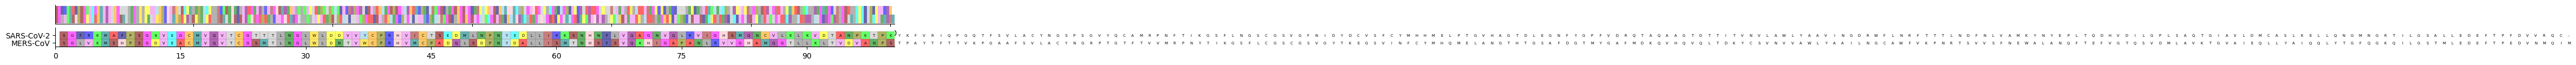

In [27]:
aln = Seq_reader('covid.aln','fasta')
aln.adjust_length()
fig, ax1, ax2 = view_alignment(aln, plot_height=1, plot_width=20, fontsize=5, img_file="CoV-Mpro_align.png")
plt.show()

Using pairwise to print pair alignments for each sequence with the reference sequence. It is not clear to me whether the alignment should be local or global

In [463]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

In [464]:
def align_to_ref(raw_seqs, ref, penalties=(2, -1, -2, -1)):
    """Use BioPython pairwise to locally align a list of sequences to a reference

    Args:
        raw_seqs (list):  A list of sequences to align to a reference (not necessaryly the same length)
        ref (string): Sequence to use as reference
        penalties (tuple, optional): Penalties associated to alignment (match, mismatch, gap, gap extension).

    Returns:
        (list, list, list): final seqs, scores, align objects
    """
    m, mm, g, e = penalties
    idx = raw_seqs.index(ref)
    alns = []
    for s in range(len(raw_seqs)):
        if s != idx:
            aln = pairwise2.align.localms(ref, raw_seqs[s], m, mm, g, e, one_alignment_only=True)
            alns.append(aln)
    final_seqs = []
    scores = []
    for i, aln in enumerate(alns):
        a = aln[0] # Result with highest score
        # print(format_alignment(*a, full_sequences=True))
        # view_alignment(raw_seqs, ref)
        seq = [a.seqA, a.seqB]
        final_seqs.append(seq)
        score = a.score
        scores.append(score)
        # print(i, seq, score)
    
    return final_seqs, scores, alns

def make_eq_len(seq_pairs, ref, raw_seqs, raw_labels):
    ''' Only works for small sequences'''

    ref_seqs = [seq[0] for seq in seq_pairs]
    comps = [seq[1] for seq in seq_pairs]

    start_indices = []
    end_indices = []

    for seq in ref_seqs:
        start_index = seq.find(ref)
        if start_index != -1:
            end_index = start_index + len(ref) - 1
        else:
            start_index = None
            end_index = None
        start_indices.append(start_index)
        end_indices.append(end_index)


    def pad(the_string, padl, padr, pad_char='-'):
        return pad_char*padl + the_string + pad_char*padr

    max_string = len(max(ref_seqs, key=len))
    print(start_indices)
    max_start = max(start_indices)
    padded_strings = []
    for i in range(len(ref_seqs)):
        extral = max_start - start_indices[i]  
        extrar = max_string - (len(comps[i]) + extral)
        padded_st = pad(comps[i], extral, extrar, pad_char='-')
        padded_ref = pad(ref_seqs[i], extral, extrar, pad_char='-')
        padded_strings.append(padded_st)

    # Correct ordering of labels
    idx = raw_seqs.index(ref)
    ref_name = raw_labels[idx]
    reordered_labels = list(filter(lambda x: x != ref_name, raw_labels))

    return [padded_ref] + padded_strings, ['REF ' + ref_name] + reordered_labels
    

Aligning and viewing test DNA sequences

[2, 0]
Aligning 3 sequences of lenght 8


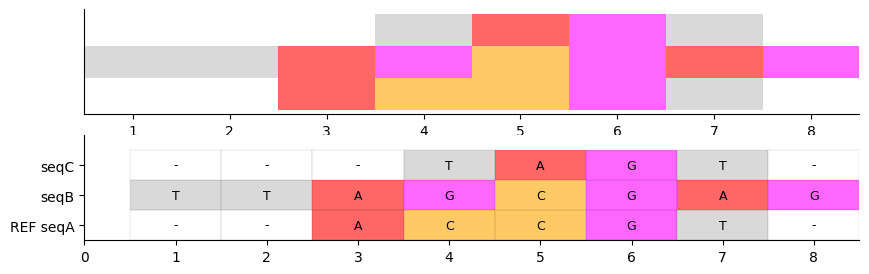

In [474]:
raw_seqs = ["ACCGT", "TTAGCGAG", "TAGT"]
ids = ['seqA', 'seqB', 'seqC']
ref = "ACCGT"
final_seqs, scores, alns = align_to_ref(raw_seqs, ref, penalties=(2, -1, -2, -1))

new_seqs, new_ids = make_eq_len(final_seqs, ref, raw_seqs, ids)

 # Build seq object
formatted_in = [(new_ids[i], new_seqs[i]) for i in range(len(new_seqs))]
aln = Seq_reader(formatted_in, format='list')
fig, ax1, ax2 = view_alignment(aln, plot_height=3, plot_width=10, fontsize=9, img_file="test.png")
plt.show()

Aligning MERS-CoV BLAST matches 

In [ ]:
aln = Seq_reader('covid.aln','fasta')
ref = aln.seqs[0]
ref_label = "MERS-CoV"
raw_seqs = matches_seq[0]
labels = [' '.join(s.split(' ')[1:5]) for s in matches_id[0]]

final_seqs, scores, alns = align_to_ref(raw_seqs, ref, penalties=(2, -1, -2, -1))
#new_seqs, new_ids = make_eq_len(final_seqs, ref, raw_seqs, labels)

# Build seq object
for s in range(2,len(final_seqs)):
    formatted_in = [(ref_label, final_seqs[s][0]), (labels[s], final_seqs[s][1])]
    aln = Seq_reader(formatted_in, format='list')
    fig, ax1, ax2 = view_alignment(aln, plot_height=3, plot_width=20, fontsize=9, img_file="mers.png")
    # plt.show()